In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import missingno as msno
from sklearn.cluster import DBSCAN

from sklearn.datasets import make_blobs
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

In [2]:
# config
np.random.seed(2123)
mv_percent = 10  # percentage of missing values created in the dataset

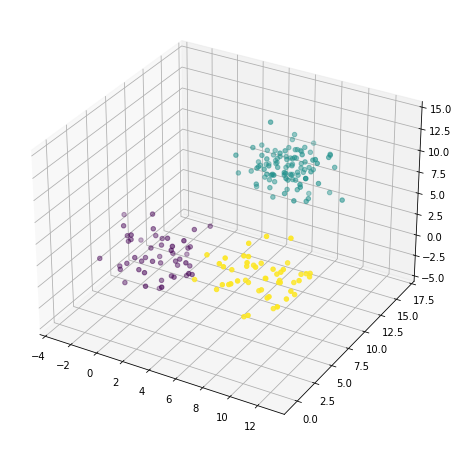

In [4]:
# create cluster dataset
features, clusters = make_blobs(n_samples=[50, 100, 50],
                                centers=[[1, 5, 1], [7, 12, 9], [10, 2, 5]],
                                n_features=3,
                                cluster_std=1.5, )

# plot dataset
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=clusters)
plt.show()

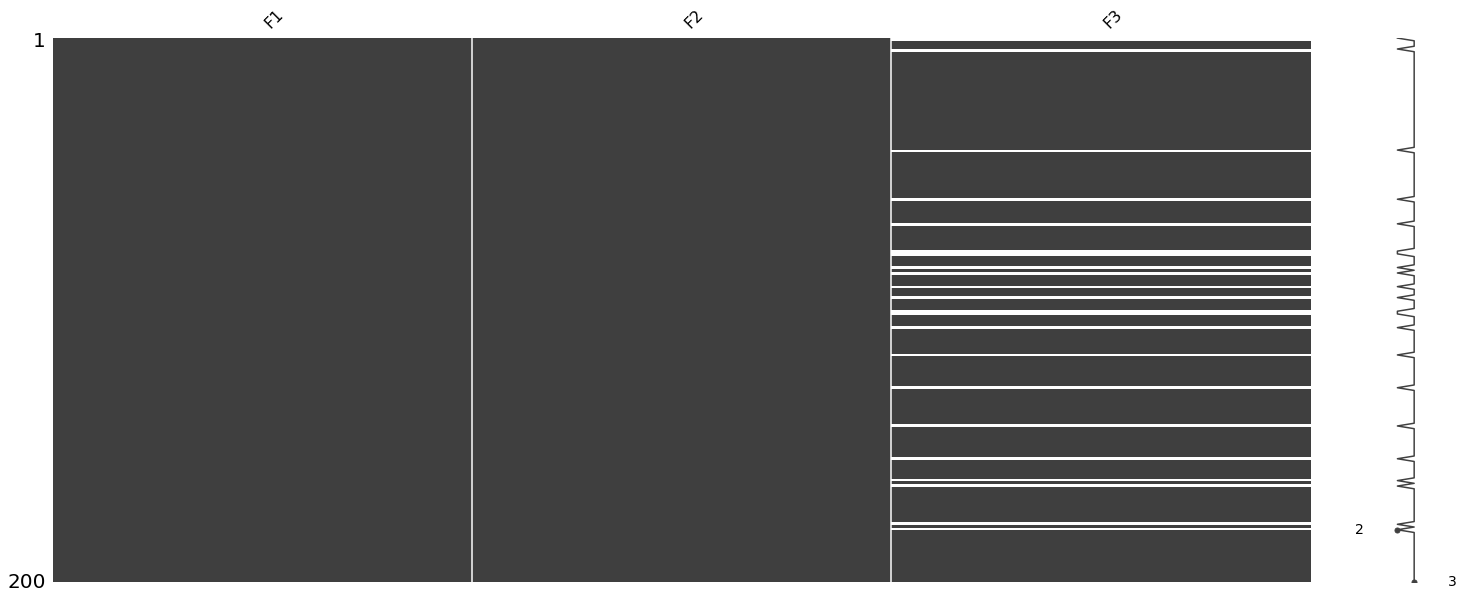

In [5]:
# create missing values
features = pd.DataFrame(features, columns=[f"F{x + 1}" for x in range(features.shape[1])])
clusters = pd.DataFrame(clusters, columns=["C"])

features_mv = features.copy()
features_mv["F3"] = features_mv["F3"].mask(np.random.random(features.shape[0]) < mv_percent / 100)

msno.matrix(features_mv)
plt.show()

In [6]:
# use TabNet to predict missing values
test = features_mv[features_mv["F3"].isna()].drop("F3", axis=1).to_numpy()
train = features_mv[features_mv["F3"].notna()]
train_features = train.iloc[:, :-1].to_numpy()
train_target = train.iloc[:, -1].to_numpy().reshape(-1, 1)

x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)

model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                        optimizer_params=dict(lr=2e-2),
                        scheduler_params={"step_size": 50, "gamma": 0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type='entmax')

model.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric=['rmse'],
    max_epochs=1000, patience=50,
)

Device used : cpu
epoch 0  | loss: 23.00194| val_0_rmse: 90.26466|  0:00:00s
epoch 1  | loss: 15.90303| val_0_rmse: 95.70086|  0:00:00s
epoch 2  | loss: 7.80951 | val_0_rmse: 84.6526 |  0:00:00s
epoch 3  | loss: 4.72081 | val_0_rmse: 77.0045 |  0:00:00s
epoch 4  | loss: 2.91774 | val_0_rmse: 55.81587|  0:00:00s
epoch 5  | loss: 2.47897 | val_0_rmse: 52.97353|  0:00:00s
epoch 6  | loss: 2.48662 | val_0_rmse: 51.69727|  0:00:00s
epoch 7  | loss: 3.02564 | val_0_rmse: 48.93339|  0:00:00s
epoch 8  | loss: 2.50028 | val_0_rmse: 44.76562|  0:00:00s
epoch 9  | loss: 2.23595 | val_0_rmse: 42.06043|  0:00:00s
epoch 10 | loss: 2.12888 | val_0_rmse: 41.33669|  0:00:00s
epoch 11 | loss: 1.91377 | val_0_rmse: 36.05664|  0:00:00s
epoch 12 | loss: 1.8117  | val_0_rmse: 32.82855|  0:00:00s
epoch 13 | loss: 1.74039 | val_0_rmse: 29.96696|  0:00:00s
epoch 14 | loss: 1.70995 | val_0_rmse: 27.54713|  0:00:00s
epoch 15 | loss: 1.61274 | val_0_rmse: 25.95554|  0:00:00s
epoch 16 | loss: 1.53894 | val_0_rmse:

epoch 144| loss: 0.06538 | val_0_rmse: 2.81651 |  0:00:04s
epoch 145| loss: 0.04469 | val_0_rmse: 2.96274 |  0:00:04s
epoch 146| loss: 0.04863 | val_0_rmse: 2.93712 |  0:00:04s
epoch 147| loss: 0.03828 | val_0_rmse: 2.8108  |  0:00:04s
epoch 148| loss: 0.0318  | val_0_rmse: 2.81586 |  0:00:04s
epoch 149| loss: 0.04085 | val_0_rmse: 2.81374 |  0:00:04s
epoch 150| loss: 0.03608 | val_0_rmse: 2.79709 |  0:00:05s
epoch 151| loss: 0.02749 | val_0_rmse: 2.83949 |  0:00:05s
epoch 152| loss: 0.02451 | val_0_rmse: 2.82662 |  0:00:05s
epoch 153| loss: 0.02682 | val_0_rmse: 2.77739 |  0:00:05s
epoch 154| loss: 0.02352 | val_0_rmse: 2.81621 |  0:00:05s
epoch 155| loss: 0.01753 | val_0_rmse: 2.85376 |  0:00:05s
epoch 156| loss: 0.02337 | val_0_rmse: 2.75855 |  0:00:05s
epoch 157| loss: 0.02336 | val_0_rmse: 2.78741 |  0:00:05s
epoch 158| loss: 0.01405 | val_0_rmse: 2.86715 |  0:00:05s
epoch 159| loss: 0.02606 | val_0_rmse: 2.78673 |  0:00:05s
epoch 160| loss: 0.01765 | val_0_rmse: 2.75521 |  0:00:0

In [7]:
# fill original dataset with predictions
features_filled = features_mv.copy()
features_filled[features_filled["F3"].isna()] = model.predict(test)

In [8]:
# apply clustering
dbscan = DBSCAN(eps=2, min_samples=10).fit(features_filled)
clusters_filled = dbscan.labels_

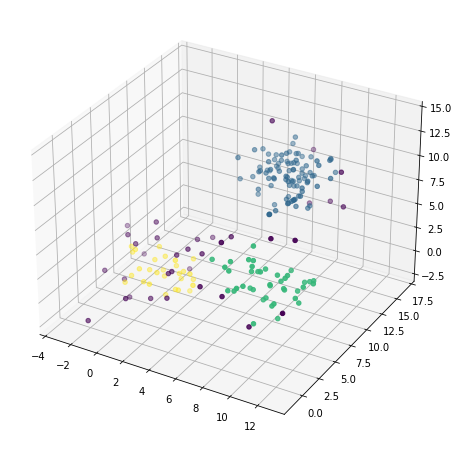

In [9]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_filled.iloc[:, 0], features_filled.iloc[:, 1], features_filled.iloc[:, 2], c=clusters_filled)
plt.show()